In [31]:
%matplotlib inline
from math import pi
import pandas as pd
from statistics import mean
import matplotlib.pyplot as plt

In [32]:
# declare parameters
earth_radius = 6371 * 1000
k_lower = 43  # W/K m, the lower estimate on core conductive heat flux (Reese & Solomotov 2010)
k_upper = 88  # W/K m, the upper estimate on core conductive heat flux (Reese & Solomotov 2010)
reynolds_magnetic_critical = 10  # the critical Magnetic Reynolds Number for a magnetic field (Reese & Solomotov 2010)
mu_0 = 4 * pi * 10 ** -7  # N/A^2, permeability of free space
sigma = 10 ** 6  # S/m, the core electrical conductivity
c_c = 840  # J/K kg, the core heat capacity (Reese * Solomotov 2010)
alpha_c = 3 * 10 ** -5  # K^-1, the core thermal expansivity (Reese * Solomotov 2010)
assumed_dT = 10 ** 4  # the assumed delta temperature due to impact heating
grav_iron_layer = 3.8  # gravitational acceleration at the iron layer depth
thickness_layer = 150 * 1000
core_radius = 3486 * 1000

In [33]:
# declare parameters to assess the thermal expansion model of the iron layer from SPH outputs
# recall, SPH will underestimate density of the layer due to contact with mantle material boundary
start_file = "0.csv"
end_file = "1000.csv"
iron_eos = "phase_data/iron_STS.table.txt"  # the EoS datatable for iron
start_df = pd.read_csv(start_file, skiprows=2)
end_df = pd.read_csv(end_file, skiprows=2)

In [34]:
# extract SPH data for given parameters above
impactor_iron_start = start_df[start_df['tag'] == 3]  # all impactor iron particles at time 0 (pre-impact)
impactor_iron_rho0 = mean(impactor_iron_start['density'])  # rho0 of impactor iron at time 0 (pre-impact)
impactor_iron_entropy = mean(impactor_iron_start['entropy'])  # entropy of impactor iron at time 0 (pre-impact)
impactor_iron_end = end_df[end_df['tag'] == 3]  # all impactor iron particles at end time (post-impact)
iron_layer_particles = impactor_iron_end[impactor_iron_end['radius'] < earth_radius]  # all impactor iron that composes the iron layer at end time (post-impact)
iron_layer_mass = sum(iron_layer_particles['mass'])  # the mass of the iron layer
print(
    "Impactor Iron Mean Entropy (t = 0): {}\n"
    "Iron Layer Mass (t = end): {} kg".format(impactor_iron_entropy, iron_layer_mass)
)

Impactor Iron Mean Entropy (t = 0): 1499.6601472124637
Iron Layer Mass (t = end): 2.2053712615394243e+23 kg


In [35]:
# declare functions to assess the thermal expansion model of the iron layer from SPH outputs
def delta_rho(alpha, rho_0, delta_T):
    """
    The change in density due to heating.
    :param alpha:
    :param rho_0:
    :param delta_T:
    :return:
    """
    return alpha * rho_0 * delta_T

def isentropes(eos, tareget_s):
    phase_df = pd.read_fwf(eos, skiprows=1,
                           names=["density", "temperature", "internal_energy", "pressure", "soundspeed", "entropy"])  # load the EoS datatable
    phase_df = phase_df[phase_df['entropy'] > 0]
    phase_df = phase_df[phase_df['entropy'] < 15000]
    phase_df = phase_df[phase_df['density'] >= 5]
    fig = plt.figure(figsize=(16, 9))
    ax = fig.add_subplot(111)
    sc = ax.tricontour(phase_df['density'], phase_df['temperature'], phase_df['entropy'], levels=10)
    c = ax.tricontour(phase_df['density'], phase_df['temperature'], phase_df['entropy'], levels=[tareget_s])
    # plt.clabel(sc, inline=1, fontsize=12)
    plt.clabel(c, inline=1, fontsize=14)
    fig.colorbar(sc, ax=ax)
    p = c.collections[0].get_paths()[0]
    v = p.vertices
    x = v[:,0]
    y = v[:,1]
    ax.set_xlim(0, 10000)
    ax.set_ylim(0, 10000)
    ax.set_xlabel("Density"), ax.set_ylabel("Temperature"), ax.set_title("Isentropic Contours")
    ax.grid()
    plt.show()
    return x, y

def isentropic_heating(eos, density, entropy):
    """
    If all heating is isentropic and the material thermally expands, then S will remain constant and rho, T will change.
    Therefore, T(rho) can be determined along a constant S curve.
    :param eos:
    :return:
    """
    phase_df = pd.read_fwf(eos, skiprows=2,
                           names=["density", "internal_energy", "temperature", "pressure", "soundspeed", "entropy"])  # load the EoS datatable
    all_isentropes = set(phase_df['entropy'])  # get all unique values for entropy
    # get the closest isentrope to the given entropy value
    min_diff, target_s = 1e10, None
    for s in all_isentropes:
        diff = abs(entropy - s)
        if diff < min_diff:
            min_diff, target_s = diff, s
    isentrope_rho, isentrope_temp = isentropes(eos=eos, tareget_s=target_s)
    min_diff, target_rho, target_t = 1e10, None, None
    for index, rho in enumerate(isentrope_rho):
        diff = abs(density - rho)
        if diff < min_diff:
            min_diff, target_rho, target_t = diff, rho, isentrope_temp[index]

    print(
        "Target S: {}, (input: {})\nTarget rho: {} (input: {})\nTarget T: {}".format(target_s, entropy, target_rho, density, target_t)
    )

    # plot the isentrope
    fig = plt.figure(figsize=(16, 9))
    ax = fig.add_subplot(111)
    ax.plot(
        isentrope_rho, isentrope_temp, linewidth=2.0, color='red', label="Isentrope"
    )
    ax.scatter(
        target_rho, target_t, color='black', marker="*", s=40, label="Target T(rho)"
    )
    ax.set_xlabel("Density"), ax.set_ylabel("Temperature"), ax.set_title("Isentropic Heating")
    ax.grid()
    ax.legend()
    plt.savefig("isentrope.png", format='png')
    plt.show()
    return target_t

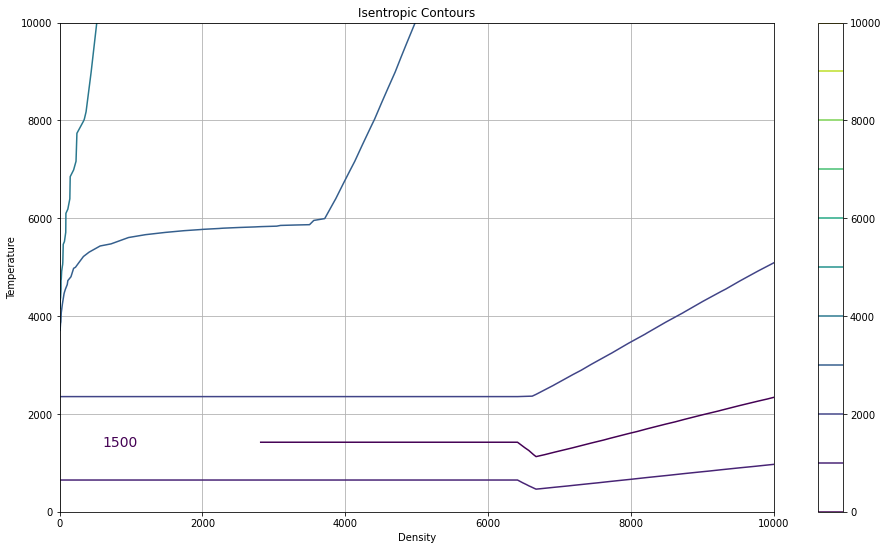

Target S: 1499.89680651, (input: 1499.6601472124637)
Target rho: 11808.744161220491 (input: 11738.633700542174)
Target T: 2959.5874964632667


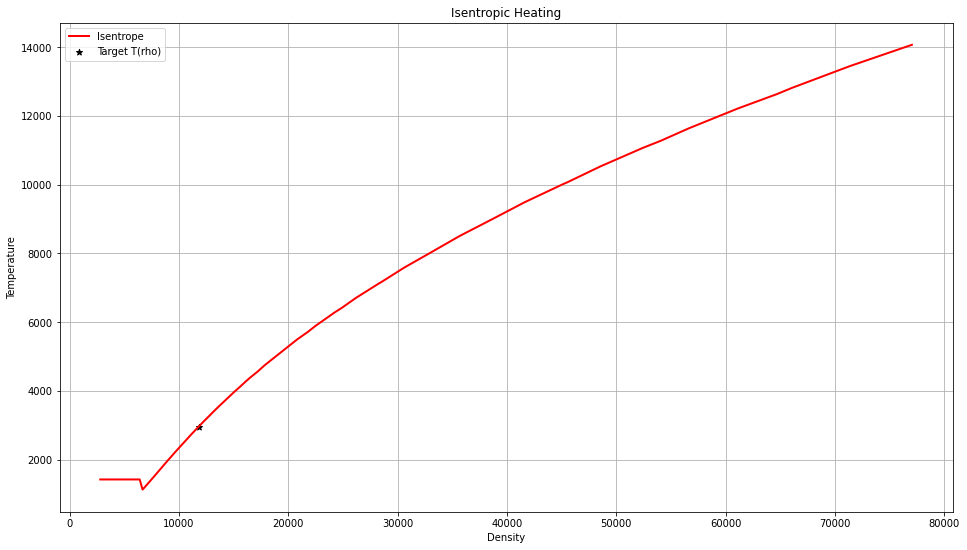

In [36]:
delta_density_exp = delta_rho(alpha=alpha_c, delta_T=assumed_dT, rho_0=impactor_iron_rho0)  # thermally expanded density
density_exp = impactor_iron_rho0 + delta_density_exp  # rho = rho_0 + delta rho
new_temp = isentropic_heating(eos=iron_eos, density=density_exp, entropy=impactor_iron_entropy)  # isentropic temperature increase

In [37]:
# declare functions for thermal convection model

def flux_conductive_adiabatic(k, alpha, g, T, c):
    """
    The conductive heat flux along an adiabat (Reese & Solomotov 2010, eq. 40).
    This gives the MINIMUM heat flux required for CONVECTION in the layer (Reese & Solomotov 2010).
    :param k:
    :param alpha:
    :param g:
    :param T:
    :param c_c:
    :return:
    """
    return (k * alpha * g * T) / c

def velocity_convective(flux_convective, g, alpha, length, rho, c):
    """
    The convective velocity.  (Reese and Solomotov 2010).
    :param flux_convective:
    :param g:
    :param alpha:
    :param length:
    :param rho:
    :param c:
    :return:
    """
    return ((flux_convective * g * alpha * length) / (rho * c)) ** (1 / 3)

def reynolds_magnetic(v_conv, z):
    """
    The magnetic Reynolds Number (Re).
    The critical value for a magentic field is 10 (Reese & Solomotov 2010).
    :param v_conv:
    :param z:
    :param sigma:
    :return:
    """
    return (v_conv * z) / (mu_0 * sigma)

def magnetic_field_strength(rho, alpha, g, flux, thickness, core_radius, c):
    """
    The magnetic field strength scaling law, from Reese & Solomotov 2010 as proposed by
    Christensen & Aubert 2006.
    :param rho:
    :param alpha:
    :param g:
    :param flux:
    :param thickness:
    :param core_radius:
    :param c:
    :return:
    """
    term1 = (mu_0 ** (1/2)) * (rho ** (1 / 6))
    term2 = ((alpha * g * flux * thickness) / (4 * pi * c * (core_radius ** 2))) ** (1 / 3)
    return term1 * term2


In [39]:
# get the values necessary to describe convection and magnetic field in the iron layer
f_c_lower = flux_conductive_adiabatic(k=k_lower, alpha=alpha_c, T=new_temp, c=c_c, g=grav_iron_layer)
f_c_upper = flux_conductive_adiabatic(k=k_upper, alpha=alpha_c, T=new_temp, c=c_c, g=grav_iron_layer)
v_lower = velocity_convective(flux_convective=f_c_lower, g=grav_iron_layer, alpha=alpha_c, length=thickness_layer, c=c_c, rho=density_exp)
v_upper = velocity_convective(flux_convective=f_c_upper, g=grav_iron_layer, alpha=alpha_c, length=thickness_layer, c=c_c, rho=density_exp)
re_mag_lower = reynolds_magnetic(v_conv=v_lower, z=thickness_layer)
re_mag_upper = reynolds_magnetic(v_conv=v_upper, z=thickness_layer)
b_lower = magnetic_field_strength(rho=density_exp, alpha=alpha_c, g=grav_iron_layer, flux=f_c_lower,
                                  thickness=thickness_layer, core_radius=core_radius, c=c_c)
b_upper = magnetic_field_strength(rho=density_exp, alpha=alpha_c, g=grav_iron_layer, flux=f_c_upper,
                                  thickness=thickness_layer, core_radius=core_radius, c=c_c)

print(
    "Adiabatic Conductive Flux (lower conductivity): {} W/m^2\n"
    "Adiabatic Conductive Flux (upper conductivity): {} W/m^2\n"
    "Convective Velocity (lower conductivity): {} m/s\n"
    "Convective Velocity (upper conductivity): {} m/s\n"
    "Magnetic Reynolds Number (lower conductivity): {}\n"
    "Magnetic Reynolds Number (upper conductivity): {}\n"
    "Magnetic Field Strength (lower conductivity): {} T\n"
    "Magnetic Field Strength (upper conductivity): {} T".format(f_c_upper, f_c_upper, v_lower, v_upper, re_mag_lower, re_mag_upper, b_lower, b_upper)
)

Adiabatic Conductive Flux (lower conductivity): 0.03534593067204701
Adiabatic Conductive Flux (upper conductivity): 0.03534593067204701
Convective Velocity (lower conductivity): 0.003105571215519741
Convective Velocity (upper conductivity): 0.003942873994968559
Magnetic Reynolds Number (lower conductivity): 370.70025755540445
Magnetic Reynolds Number (upper conductivity): 470.6459147158013
Magnetic Field Strength (lower conductivity): 7.056678371255442e-09
Magnetic Field Strength (upper conductivity): 8.959251522500888e-09
